Log entry 02/11/2021:

Currently learnt from stochastic gradient descent: next parameter for used for learning is data order dependent. train set of data on target model and surrogate model for one epoch + store each datapoint to local variable, must be done so all datapoints can be seen. once all data points seen, you can assign each datapoint a value of how much each datapoint's loss value is on surrogate model to estimate target model's loss on datapoint. using this value, can reorder all datapoints sent to train target model in different ways to mess with the model's accuracy.

```abalone.data``` obtained from UCI Learning Repository: https://archive.ics.uci.edu/ml/datasets/abalone

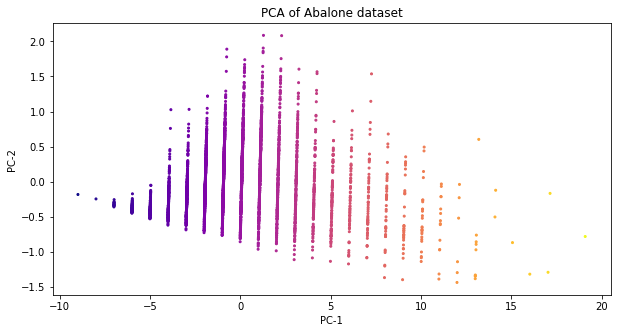

SGDClassifier(eta0=0.2, learning_rate='constant', loss='log', max_iter=100,
              penalty='elasticnet', shuffle=False)

In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Configuration values
HIGH_LOW = 'highlow'
LOW_HIGH = 'lowhigh'
OSC_IN = 'oscillatingin'
OSC_OUT = 'oscillatingout'
BATCH_REORDER = 'reorder'
BATCH_RESHUFFLE = 'reshuffle'
N_TESTDATA_SAMPLES = 150
NUM_ITER = 100
N = 1476


# Read the abalone.data file into a pandas dataframe
df = pd.read_csv('abalone.data')


# Declare what our feature vectors and class vectors are
features = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
classVector = 'rings'


# Assign a header/title to each feature
df.set_axis(features, axis=1, inplace=True)
features.remove('sex')


# Visualise the data on a 2D plane through PCA dimensionality reduction
pca = PCA(n_components=2)
pcs = pca.fit(df[features]).components_
reducedData = np.matmul((df[features]-df[features].mean()).to_numpy(), pcs.transpose())
dfReduced = pd.DataFrame(data=reducedData, columns=['PC-1', 'PC-2'])
plt.scatter(reducedData[:, 0], reducedData[:, 1], s=4, c=df[classVector].to_list(), cmap='plasma')

plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('PCA of Abalone dataset')
plt.gcf().set_size_inches(10, 5)
plt.show()



# Split dataset into a training dataset and testing dataset
trainingData = df[features][:-N_TESTDATA_SAMPLES]
trainingLabels = df[classVector][:-N_TESTDATA_SAMPLES]

testData = df[features][-N_TESTDATA_SAMPLES:]
testLabels = df[classVector][-N_TESTDATA_SAMPLES:]


# Create identical SGD Classifier control and target models
control = SGDClassifier(loss='log', penalty='elasticnet', max_iter=100, tol=0.001, shuffle=False, learning_rate='constant', eta0=0.2)
target = SGDClassifier(loss='log', penalty='elasticnet', max_iter=100, tol=0.001, shuffle=False, learning_rate='constant', eta0=0.2)


# Surrogate model which the attacker is using to predict Iris classification, different configuration to the control/target models
surrogate = SGDClassifier(loss='hinge', max_iter=90, tol=0.001, shuffle=False, learning_rate='constant', eta0=0.2)


# Get a numpy array of all possible class labels in dataset
classLabels = np.unique(df[classVector].to_numpy())


# Train the models over one epoch of datapoints in a currently natural non-malicious order
control.partial_fit(X=trainingData, y=trainingLabels, classes=classLabels)
surrogate.partial_fit(X=trainingData, y=trainingLabels, classes=classLabels)
target.partial_fit(X=trainingData, y=trainingLabels, classes=classLabels)



In [15]:

# Utility method to determine if SGDClassifier classification was accurate or not
def accuracy(x, y):
    return x == y


#===== ATTACK =====
def attack(attackType, batchType):

    datapoints = []
    datatargets = []
    datacosts = {}

    for i in range(len(trainingData)):
        # Read each datapoint, evaluate the accuracy, record these values
        point = trainingData.iloc[i:i+1]
        label = trainingLabels.iloc[i]
        loss = accuracy(surrogate.predict(point)[0], label)
        datapoints.append(point)
        datatargets.append(label)
        datacosts[i] = loss

    
    # Reorder datapoint indecies by ascending order of loss
    reorderedCosts = dict(sorted(datacosts.items(), key = lambda item: item[1]))

    reorderedData = []
    reorderedLabels = []

    for index in reorderedCosts:
        # Reorder datapoints and their classes based on redordered indecies
        reorderedData.append(datapoints[index])
        reorderedLabels.append(datatargets[index])

    reorderedData = pd.concat(reorderedData)

    #START OF TO BE COMPLETED WORK
    if attackType == HIGH_LOW:
        # Reverse order of reordered data if high -> low attack type
        reorderedData = [reorderedData[0][::-1], reorderedData[1][::-1], reorderedData[2][::-1]]
        reorderedLabels = reorderedLabels[::-1]

    if attackType == OSC_OUT:
        # Invert each half of reordered data if oscillating out attack type
        right = reorderedData[len(reorderedData)//2:][::-1]
        left = reorderedData[:len(reorderedData)//2][::-1]
        reorderedData = left + right

        right = reorderedLabels[len(reorderedLabels)//2:][::-1]
        left = reorderedLabels[:len(reorderedLabels)//2][::-1]
        reorderedLabels = left + right
    #END OF TO BE COMPLETED WORK
    
    control.partial_fit(X=trainingData, y=trainingLabels)
    target.partial_fit(X=reorderedData, y=np.ravel(reorderedLabels))
    surrogate.partial_fit(X=reorderedData, y=np.ravel(reorderedLabels))

accuracies = []

for i in range(NUM_ITER):
    attack(LOW_HIGH, None)
    accuracies.append(control.score(testData, testLabels) - target.score(testData, testLabels))


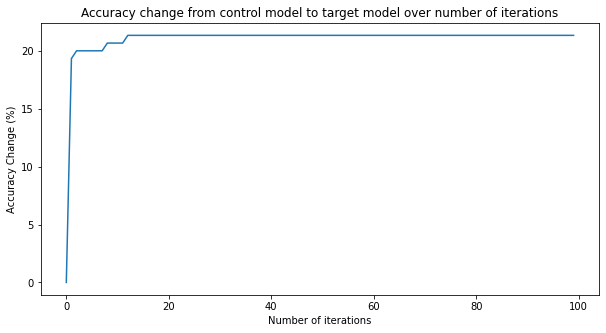

The peak accuracy change is identified after 13 iterations with an accuracy change of 21.33%.
The change in accuracy percentages reaches convergence beyond this limit.


In [17]:
# Multiply accuracy change values by 100 for percentages
percentageAcc = np.array(accuracies) * 100

# Plot graph of accuracy variation with number of iterations during trainijng
plt.plot(range(NUM_ITER), percentageAcc)
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy Change (%)')
plt.title('Accuracy change from control model to target model over number of iterations')
plt.gcf().set_size_inches(10, 5)
plt.show()
print("The peak accuracy change is identified after " + str(np.argmax(percentageAcc) + 1) + " iterations with an accuracy change of " + str(round(np.max(percentageAcc), 2)) + "%.")
print("The change in accuracy percentages reaches convergence beyond this limit.")